In [23]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("groq_api_key")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [24]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")

from langgraph.graph import MessagesState
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages


In [61]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    


In [76]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
import re

# SystemMessage

sys_message = SystemMessage(content = 'You are a AI blog writer. You will be given a topic and you will create a catchy title for the {topic}')
sys_message1 = SystemMessage(content = ' You are an expert AI blog writer. You will write a detailed blog based on the {title}. You will generate the blog in 3 different sections:\
    1. Introduction (a brief introduction to the topic and stating the importance of the topic. This will be within 50 to 75 words)\
    2. Main body content containing technical problems and solution or a detailed explanation of the topic within 350 words.\
    3. Conclusion (a brief conclusion to the topic and stating the importance of the topic. This will be within 50 to 75 words)')
sys_message2 = SystemMessage(content = 'You are expert Editor who is been assigned to review the blog title and the main body content.\
    If everything is fine, then you will provide good blog as feedback.\
    If title is not catchy, then you will provide a change title as feedback.\
    If main body content is not good, then you will provide a change content as feedback.')
 
    
# def blog_assistant(state: MessagesState):
#     return {"messages": [sys_message] + state["messages"]}

def title_creator(state:MessagesState): 
    '''Create a title for the blog post based on the messages in the state'''
    title = llm.invoke([sys_message] + state['messages'] )
    
    return {"message": state['messages'] + [title] }
    
    
def content_creator(state: MessagesState):
    ''' Create a content for the blog based on the title'''
    
    
    title = state["messages"][-1]
    
    main_body = llm.invoke([sys_message1, title])
    return {'messages':  state['messages']+ [main_body]}


def editor(state: MessagesState):
    '''Review the blog title and content'''
    messages = state["messages"]
    
    title = messages[-2].content
    print(title)
    content = messages[-1].content
    print(content)
    
    editor_feedback = llm.invoke([sys_message2, title, content])
    match = re.search(r"\b(approved|change_title|change_content)\b", editor_feedback.content.lower())

    feedback = match.group(1)
   
    
    
    valid_feedback = ["approved", "change_title", "change_content"]
    if feedback not in valid_feedback:
        raise ValueError(f" Unexpected feedback from LLM: {feedback}")

    return {"editor_feedback": feedback}
    
    

def editor_decision(state:MessagesState):
    '''Check if the editor has provided a good blog or not'''
    messages = state['messages']
    
    feedback = state['editor_feedback']
    
     
    
    if feedback == 'approved':
        return 'Accepted'
    
    if feedback == 'change title':
        return 'Change Title'
    
    if feedback == 'change content':
        return 'Improve Content'
    
    
    







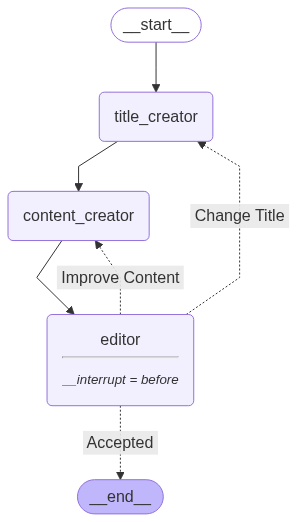

In [77]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()
builder = StateGraph(MessagesState)

# builder.add_node("assistant", blog_assistant)
builder.add_node("title_creator", title_creator)
builder.add_node("content_creator", content_creator)
builder.add_node("editor", editor)

builder.add_edge(START, "title_creator")
builder.add_edge("title_creator", "content_creator")
builder.add_edge("content_creator", "editor")
builder.add_conditional_edges('editor', editor_decision, {
    'Accepted': END,
    'Change Title': "title_creator",
    'Improve Content': "content_creator"
}
)


blog_graph = builder.compile(interrupt_before= ['editor'],checkpointer=memory)

display(Image(blog_graph.get_graph().draw_mermaid_png()))





In [78]:
messages = {"messages":HumanMessage(content="Write a blog post about playing outdoor sports")}
thread = {'configurable':{'thread_id': '1'}}


In [79]:
for event in blog_graph.stream(messages, thread, stream_mode = 'values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Write a blog post about playing outdoor sports
================================== Ai Message ==================================

**Title: The Importance of Playing Outdoor Sports**

**Introduction:**

Playing outdoor sports is not just a recreational activity; it's a vital component of a healthy lifestyle. Engaging in outdoor sports can improve physical health, mental well-being, and social skills. Whether it's team sports like soccer and basketball or individual pursuits like running and cycling, outdoor sports offer a myriad of benefits that enhance the quality of life.

**Main Body:**

Outdoor sports are a fantastic way to stay physically active and maintain fitness levels. They help in building endurance, muscle strength, and cardiovascular health. Engaging in such activities regularly can reduce the risk of chronic diseases, such as heart disease, diabetes, and obesity. Moreover, the exposure to fres